In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
from matplotlib import colors
import spe2py as spe
from cellpose import models
import cellpose
import time
import cv2
from skimage import draw

In [2]:
spe_tools = spe.load()

XML Footer was not loaded prior to calling _get_wavelength or 
XML Footer does not contain Wavelength Mapping information
XML Footer was not loaded prior to calling _get_wavelength or 
XML Footer does not contain Wavelength Mapping information
Successfully loaded 2 file(s) in a list of SpeFile objects
File(s) have been loaded into SpeTool objects


In [3]:
frame_count_b = 0
for i in spe_tools[0].file.data[:]:
    frame_count_b += 1
print('Number of Frame, BrightField: ', frame_count_b)

roi_count_b = 0
for i in spe_tools[0].file.data[0]:
    roi_count_b += 1
print('Number of ROI, BrightField: ', roi_count_b)

frame_count_f = 0
for i in spe_tools[1].file.data[:]:
    frame_count_f += 1
print('Number of Frame, Fluorescence: ', frame_count_f)

roi_count_f = 0
for i in spe_tools[1].file.data[0]:
    roi_count_f += 1
print('Number of ROI, Fluorescence: ', roi_count_f)

Number of Frame, BrightField:  7
Number of ROI, BrightField:  1
Number of Frame, Fluorescence:  15
Number of ROI, Fluorescence:  1


In [ ]:
'''
for i in range(0, frame_count_b):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
    mappable = ax.imshow(spe_tools[0].file.data[i][0], cmap='hot')
    fig.colorbar(mappable ,fraction=0.0495, pad=0.04) #set the colorbar size match to the contour size
'''

In [ ]:
'''
for i in range(0, frame_count_f):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
    mappable = ax.imshow(spe_tools[1].file.data[i][0], cmap='summer')
    fig.colorbar(mappable ,fraction=0.0495, pad=0.04)
'''

In [ ]:
'''
temp_b = []
for i in range(0, frame_count_b):
    temp_b.append(spe_tools[0].file.data[i][0][0][10])

coef = np.polyfit(np.arange(0, frame_count_b), temp_b, 1)
ploy1d_f = np.poly1d(coef)

plt.plot(np.arange(0, frame_count_b), temp_b, 'ro')
plt.plot(np.arange(0, frame_count_b), ploy1d_f(np.arange(0, frame_count_b)), 'b--')
'''

In [ ]:
'''
temp_f = []
for i in range(0, frame_count_f):
    temp_f.append(spe_tools[1].file.data[i][0][0][10])

coef = np.polyfit(np.arange(0, frame_count_f), temp_f, 1)
ploy1d_f = np.poly1d(coef)

plt.plot(np.arange(0, frame_count_f), temp_f, 'go')
plt.plot(np.arange(0, frame_count_f), ploy1d_f(np.arange(0, frame_count_f)), 'b--')
'''

In [4]:
# Fit intensity at different pixles at different time frames
x = np.arange(0, frame_count_b)
slope_matrix_b = np.zeros((640, 512))

t0 = time.perf_counter()
for i in range(0, 512):
    for j in range(0, 640):
        intensity_frame = []
        for k in range(0, frame_count_b):
            intensity_frame.append(spe_tools[0].file.data[k][0][j][i])
        coef = np.polyfit(x, intensity_frame, 1)
        slope_matrix_b[j][i] = coef[0]

t1 = time.perf_counter()
print(t1-t0, 'seconds')

17.73421673499979 seconds


In [5]:
x = np.arange(0, frame_count_f)
slope_matrix_f = np.zeros((640, 512))

t0 = time.perf_counter()
for i in range(0, 512):
    for j in range(0, 640):
        intensity_frame = []
        for k in range(0, frame_count_f):
            intensity_frame.append(spe_tools[1].file.data[k][0][j][i])
        coef = np.polyfit(x, intensity_frame, 1)
        slope_matrix_f[j][i] = coef[0]

t1 = time.perf_counter()
print(t1-t0, 'seconds')

19.283006488999945 seconds


In [ ]:
slope_matrix_f.shape

In [ ]:
# Convert slope_matrix_b to .tiff as it is supported by cellpose.io.imread
plt.imsave('./save_tiff/b_no9_3_0712.tiff', arr=slope_matrix_b, cmap='gray')

In [7]:
t0 = time.perf_counter()

# model_type='cyto' or 'nuclei' or 'cyto2'
model = models.Cellpose(model_type='cyto')

# list of files
files = [r'./save_tiff/b_no9_3_0712.tiff']

imgs = [cellpose.io.imread(f) for f in files]
nimg = len(imgs)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)

t1 = time.perf_counter()

print(t1-t0, 'seconds')

19.64980781200029 seconds


In [ ]:
#type(masks) == list
#np.array(masks).shape == (1, 640, 512,)
#np.array(flows).shape == (1, 4, ?, 3)
#np.array(styles).shape == (1, 256,)
#np.array(diams).shape == (1,)

In [ ]:
cellpose.io.masks_flows_to_seg(images=imgs,
                               masks=masks,
                               flows=flows,
                               diams=diams,
                               file_names=['./output_npy/b_no9_3_0712'],
                               channels=None)


In [6]:
seg = np.load('./output_npy/b_no9_3_0712_seg.npy', allow_pickle=True)

In [8]:
# Solve: IndexError: too many indices for array: array is 0-dimensional, but 1 were index
seg_temp = seg.tolist()

print(seg_temp.keys())

dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])


In [ ]:
# 4 channels
#temp['img'].shape == (640, 512, 4), temp['img'].dtype == uint8
#temp['outlines'].shape == (640, 512)

In [9]:
outlines = np.zeros((640, 512))
for i in range(0, 640):
    for j in range(0, 512):
        if seg_temp['outlines'][i][j] > 0:
            outlines[i][j] = 1
        else:
            pass

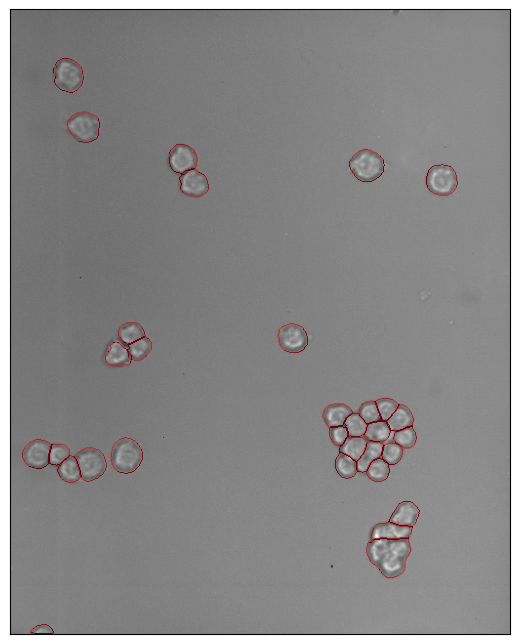

In [10]:
fig = plt.figure(figsize=(3200/640, 3200/512))
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(slope_matrix_b, cmap='gray')
ax.imshow(outlines*100, cmap='Reds', alpha=outlines, vmax=100, vmin=-100)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#plt.savefig(r'./final_output/segb_no9_3_0712.tiff')

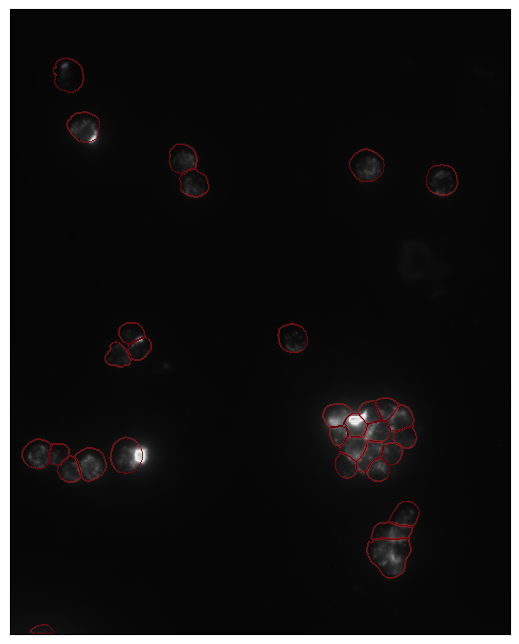

In [11]:
fig = plt.figure(figsize=(3200/640, 3200/512))
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(slope_matrix_f, cmap='gray')
ax.imshow(outlines*100, cmap='Reds', alpha=outlines, vmax=100, vmin=-100)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#plt.savefig(r'./final_output/segf_no9_3_0712.tiff')

In [ ]:
mask_temp = np.zeros((640, 512,))
for index in np.argwhere(masks[0]>0):
    mask_temp[index[0]][index[1]] = 1

In [ ]:
cellpose.io.save_masks([r'./save_tiff/b_no9_3_0712.tiff'],
                      masks=masks,
                      flows=flows,
                      file_names=['./output_mask/no9_3_0712'],
                      png=False,
                      tif=False,
                      save_txt=True)

In [12]:
boundaries: list = []
with open('./output_mask/no9_3_0712_cp_outlines.txt') as f:
    lines = f.readlines()
    for line in lines:
        pure_line: list = line.split('\n')[0]
        pure_number: list = pure_line.split(',')
        pixel_index = [(int(pure_number[i]), int(pure_number[i+1])) for i in range(0, len(pure_number), 2)]
        boundaries.append(pixel_index)

In [27]:
cell_mask:list = []
label_mask = np.full((640,512), fill_value=-1, dtype=int)

for cell_num in range(len(boundaries)):
    h_coord = [tup[1] for tup in boundaries[cell_num]]
    w_coord = [tup[0] for tup in boundaries[cell_num]]
    h_coord = np.array(h_coord)
    w_coord = np.array(w_coord)
    if np.count_nonzero(h_coord==639) > 5 or np.count_nonzero(h_coord==1) > 5\
        or np.count_nonzero(w_coord==511) > 5 or np.count_nonzero(w_coord==1) > 5:
        #print(cell_num)
        continue
    else:
        modified_boundary = [(tup[1], tup[0]) for tup in boundaries[cell_num]]
        single_mask_temp = draw.polygon2mask((640, 512), np.array(modified_boundary))
        cell_mask.append(1-single_mask_temp)
        label_mask += single_mask_temp.astype(int)*(cell_num+1)

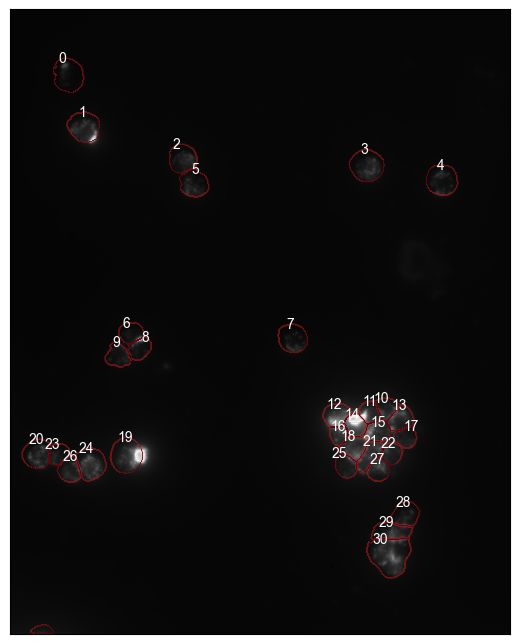

In [42]:
fig = plt.figure(figsize=(3200/640, 3200/512))
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(slope_matrix_f, cmap='gray')
ax.imshow(outlines*100, cmap='Reds', alpha=outlines, vmax=100, vmin=-100)

label_temp = 0
for label_num in range(len(cell_f_sum)):
    coord = (np.where(label_mask==label_num)[0][0], np.where(label_mask==label_num)[1][0])
    ax.text(coord[1], coord[0], int(label_num), ha='center', va='center', c='white')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.savefig(r'./final_output/segf2_no9_3_0712.tiff')

In [14]:
cell_f_sum:list = []
for single_cell_mask in cell_mask:
    cell_fluorescence = np.ma.masked_array(slope_matrix_f, single_cell_mask)
    cell_sum = np.sum(cell_fluorescence)
    #print(cell_sum)
    cell_f_sum.append(cell_sum)
#print(len(cell_f_sum))

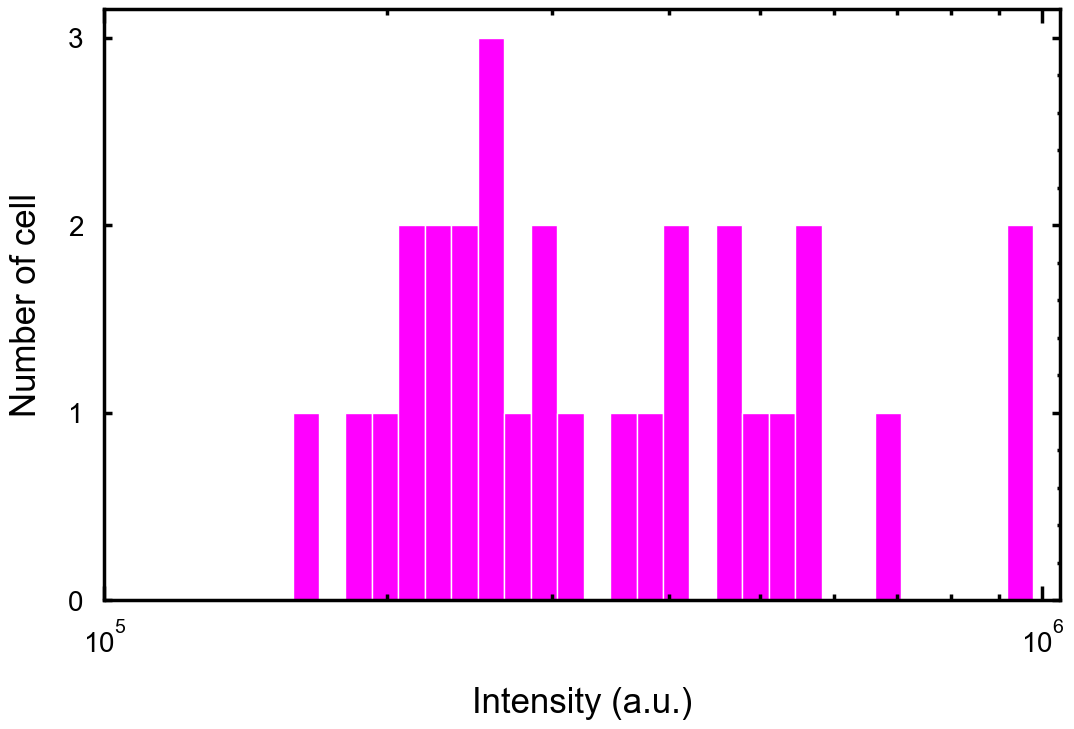

In [15]:
fig = plt.figure(figsize=(13, (13-1.5)/1.618))
ax = fig.add_axes([0.26, 0.15, 0.735, 0.735*13/(13-1.5)])

bins = np.array(sorted(cell_f_sum))
# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

ax.hist(cell_f_sum, bins=logbins, color='fuchsia', edgecolor='white')

ax.set_xlim(bins[0], bins[-1])
ax.set_xticks(np.logspace(5, 6, num=10))
#ax.set_ylim(0, 25)
ax.set_yticks(np.arange(0, 4))

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xscale('log')

ax.set_xlabel('Intensity (a.u.)', fontsize=25, labelpad=20)
ax.set_ylabel('Number of cell', fontsize=25, labelpad=18)

ax.minorticks_on()
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=15/1.5, top='on', direction='in', pad=15)
ax.xaxis.set_tick_params(which='minor', labelsize=20, width=2.5, length=6/1.5, top='on', direction='in')

ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=15/2.5, right='on', direction='in', pad=15)
ax.yaxis.set_tick_params(which='minor', labelsize=20, width=2.5, length=6/2.5, right='on', direction='in')
ax.tick_params(axis='y', which='minor', left=False)
#ax.ticklabel_format(style='plain')

for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set_linewidth(2.5)

In [ ]:
bins

In [ ]:
np.array(cell_mask).shape